# Capstone Project

In [1]:
# Imports
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from xgboost import XGBClassifier

In [2]:
# load data
random_state = 42
df = pd.read_csv('./data/train.csv')

In [3]:
# Show the first 5 rows of the dataset
print(df.head())

   ACTION  RESOURCE  MGR_ID  ROLE_ROLLUP_1  ROLE_ROLLUP_2  ROLE_DEPTNAME  \
0       1     39353   85475         117961         118300         123472   
1       1     17183    1540         117961         118343         123125   
2       1     36724   14457         118219         118220         117884   
3       1     36135    5396         117961         118343         119993   
4       1     42680    5905         117929         117930         119569   

   ROLE_TITLE  ROLE_FAMILY_DESC  ROLE_FAMILY  ROLE_CODE  
0      117905            117906       290919     117908  
1      118536            118536       308574     118539  
2      117879            267952        19721     117880  
3      118321            240983       290919     118322  
4      119323            123932        19793     119325  


In [4]:
# Show a quick description of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
ACTION              32769 non-null int64
RESOURCE            32769 non-null int64
MGR_ID              32769 non-null int64
ROLE_ROLLUP_1       32769 non-null int64
ROLE_ROLLUP_2       32769 non-null int64
ROLE_DEPTNAME       32769 non-null int64
ROLE_TITLE          32769 non-null int64
ROLE_FAMILY_DESC    32769 non-null int64
ROLE_FAMILY         32769 non-null int64
ROLE_CODE           32769 non-null int64
dtypes: int64(10)
memory usage: 2.5 MB


In [5]:
# find different number of categories for each feature
for attr in df:
    print('\n')
    print(df[attr].value_counts())



1    30872
0     1897
Name: ACTION, dtype: int64


4675      839
79092     484
25993     409
75078     409
3853      404
6977      299
75834     299
32270     295
42085     247
17308     239
1020      236
13878     220
42093     204
18418     192
7543      186
23921     167
278393    163
34924     161
79121     157
28149     137
18072     136
20364     135
39262     129
14354     127
23096     126
75901     115
15064     113
33054     108
20897     104
33642      99
         ... 
35046       1
92378       1
100413      1
79728       1
79792       1
36894       1
28635       1
59370       1
45057       1
30629       1
18462       1
38809       1
77905       1
42879       1
75631       1
39012       1
30565       1
18275       1
79693       1
97530       1
28793       1
18243       1
20290       1
26407       1
43202       1
35014       1
75535       1
30936       1
89856       1
16376       1
Name: RESOURCE, Length: 7518, dtype: int64


770       152
2270       99
2594       82
1350  

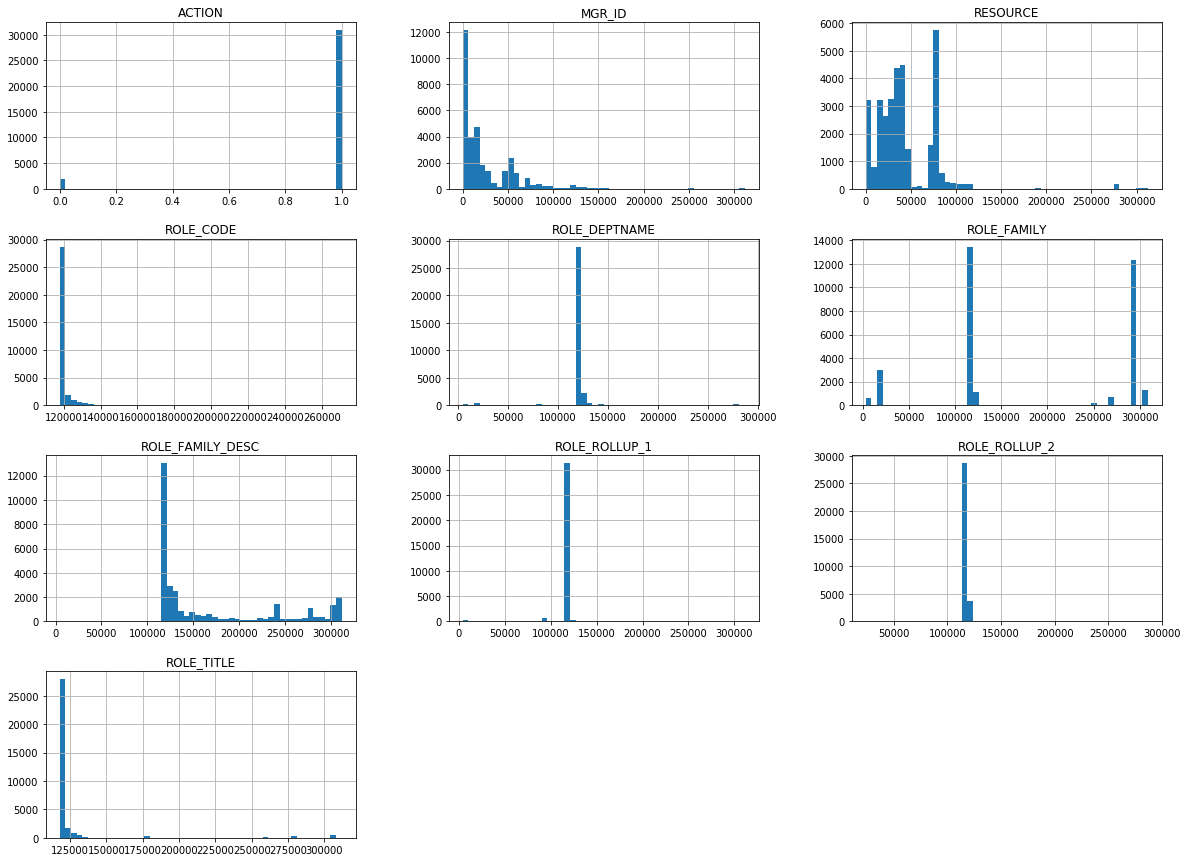

In [6]:
# draw histograms for each attribute
df.hist(bins=50, figsize=(20, 15))
plt.show()

In [7]:
# set aside a test set
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=random_state)
for train_index, test_index in sss.split(df, df['ACTION']):
    train_set, test_set = df.loc[train_index], df.loc[test_index]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f294a290898>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f294a225080>]], dtype=object)

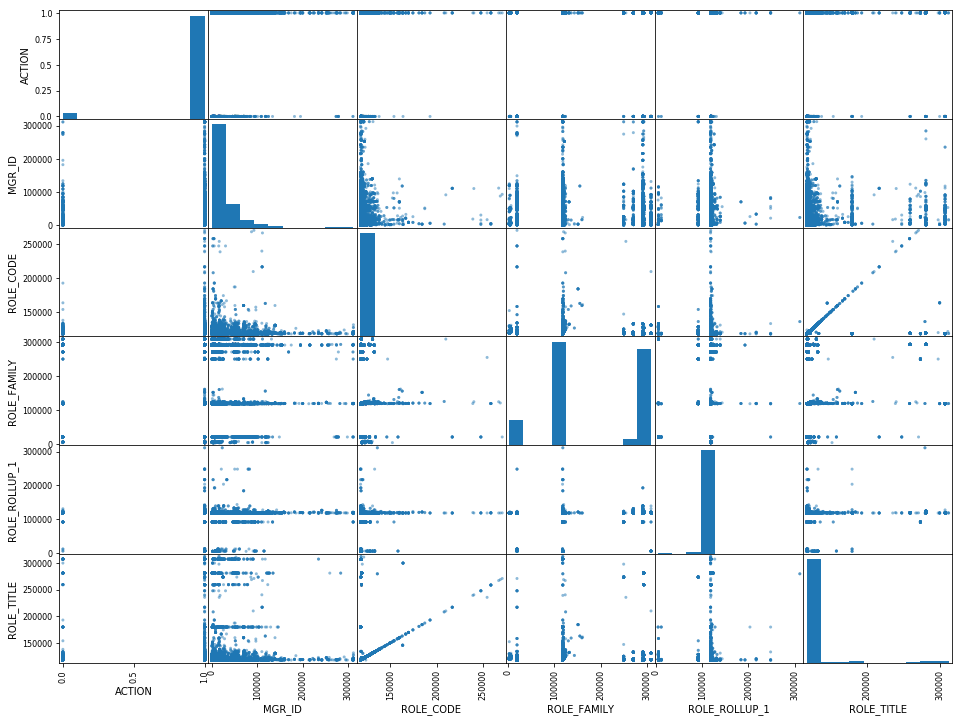

In [8]:
from pandas.plotting import scatter_matrix
#attributes = list(access.columns.values)
attributes = ['ACTION',  'MGR_ID', 'ROLE_CODE', 'ROLE_FAMILY',
            'ROLE_ROLLUP_1', 'ROLE_TITLE']
scatter_matrix(train_set[attributes], figsize=(16, 12))

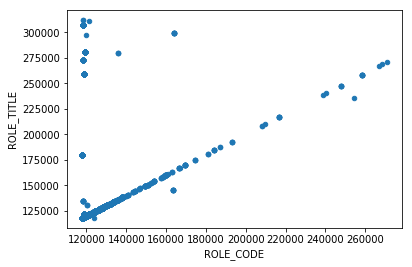

In [9]:
train_set.plot(kind='scatter', x='ROLE_CODE', y='ROLE_TITLE')

In [10]:
# extract labels and predictors 
access = train_set.drop('ACTION', axis=1)
access_labels = train_set['ACTION'].copy()

In [11]:
# Data frame selector class, taken from "Hands-On Machine Learning with Scikit-Learn & Tensorflow by Aurélion Géron
# (O'Reilly). Copyright 2017 Aurélion Géron, 978-1-491-96229-9, Page 41
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [12]:
# get attributes
attributes = access.columns.values.tolist()

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# one-hot encode the categorial attributes
pipeline = Pipeline([
    ('selector', DataFrameSelector(attributes)),
    ('encoder', OneHotEncoder())
])
access_1hot = pipeline.fit_transform(access)
print('Shape: ', access_1hot.shape)

Shape:  (24576, 14064)


In [14]:
from sklearn.metrics import roc_auc_score

# displays the area under the roc curve score for the specified model
def display_single_auc_result(model):
    access_predictions = model.predict(access_1hot)
    auc = roc_auc_score(access_labels, access_predictions)
    print('Single AUC score: ', auc)
    

In [15]:
from sklearn.model_selection import cross_val_score

# display cross validation auc scores, mean and standard deviation for the specified model 
# using the one-hot encoded training set and the corresponding labels
def display_auc_scores(model, folds=10):
    scores = cross_val_score(model, access_1hot, access_labels, scoring='roc_auc', cv=folds)
    print('--- Cross validation scores ---')
    print('Scores: ', scores)
    print('Mean: ', scores.mean())
    print('Std: ', scores.std())

In [16]:
def display_models(models):
    for i, (model, model_name) in enumerate(models):
        model.fit(access_1hot, access_labels)
        print('-------------------')
        print(model_name + ':')
        display_single_auc_result(model)
        display_auc_scores(model)
        print('-------------------')


In [17]:
# initialize many different models

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier


log_reg = LogisticRegression(random_state=random_state)
decision_tree = DecisionTreeClassifier(random_state=random_state)
random_forest = RandomForestClassifier(random_state=random_state)
ada_boost = AdaBoostClassifier(random_state=random_state)
svm_clf = SVC()
xg_boost = XGBClassifier()



models = [(log_reg, 'Logistic Regression'), (decision_tree, 'Decision Tree'), (random_forest, 'Random Forest'),
         (ada_boost, 'Ada Boost'),(svm_clf, 'SVM'), (xg_boost, 'XG Boost')]

display_models(models)

-------------------
Logistic Regression:
Single AUC score:  0.669069854877
--- Cross validation scores ---
Scores:  [ 0.86783489  0.79915939  0.79383764  0.87851276  0.85076963  0.86988866
  0.86555532  0.85809023  0.84325891  0.86433091]
Mean:  0.849123832676
Std:  0.0279584525412
-------------------
-------------------
Decision Tree:
Single AUC score:  1.0
--- Cross validation scores ---
Scores:  [ 0.72610421  0.65552647  0.6762896   0.72783896  0.71368905  0.69061844
  0.69895659  0.71986737  0.71584887  0.69457153]
Mean:  0.701931108193
Std:  0.0221609635745
-------------------
-------------------
Random Forest:
Single AUC score:  0.977502388022
--- Cross validation scores ---
Scores:  [ 0.82683551  0.7928367   0.76518171  0.83157302  0.82173668  0.8546634
  0.82847778  0.84174855  0.82905424  0.83863353]
Mean:  0.823074112209
Std:  0.0245105581892
-------------------
-------------------
Ada Boost:
Single AUC score:  0.534673619549
--- Cross validation scores ---
Scores:  [ 0.73761

In [18]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import scipy.stats

# Tune n_estimators for Random forest
param_rf = {'n_estimators': [5, 10, 20, 30, 40, 50]}
grid_search = GridSearchCV(estimator = RandomForestClassifier(random_state=random_state, verbose=3), 
    param_grid = param_rf, scoring='roc_auc', iid=False, cv=5)
grid_search.fit(access_1hot, access_labels)

building tree 1 of 5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 5


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


building tree 3 of 5
building tree 4 of 5
building tree 5 of 5


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


building tree 1 of 5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 5


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


building tree 3 of 5
building tree 4 of 5
building tree 5 of 5


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


building tree 1 of 5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 5


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


building tree 3 of 5
building tree 4 of 5
building tree 5 of 5


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


building tree 1 of 5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 5


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


building tree 3 of 5
building tree 4 of 5
building tree 5 of 5


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


building tree 1 of 5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 5


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


building tree 3 of 5
building tree 4 of 5
building tree 5 of 5


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 20


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   10.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.4s finished


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 20


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   11.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.4s finished


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 20


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   11.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.4s finished


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 20


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   10.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.4s finished


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 20


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   11.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.4s finished


building tree 1 of 30


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 30


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   16.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.6s finished


building tree 1 of 30


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 30


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   16.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.6s finished


building tree 1 of 30


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 30


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   16.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.6s finished


building tree 1 of 30


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 30


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   16.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.6s finished


building tree 1 of 30


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 30


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   17.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.6s finished


building tree 1 of 40


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 40


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


building tree 3 of 40
building tree 4 of 40
building tree 5 of 40
building tree 6 of 40
building tree 7 of 40
building tree 8 of 40
building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   22.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.8s finished


building tree 1 of 40


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 40


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


building tree 3 of 40
building tree 4 of 40
building tree 5 of 40
building tree 6 of 40
building tree 7 of 40
building tree 8 of 40
building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   22.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.8s finished


building tree 1 of 40


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 40


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


building tree 3 of 40
building tree 4 of 40
building tree 5 of 40
building tree 6 of 40
building tree 7 of 40
building tree 8 of 40
building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   22.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.8s finished


building tree 1 of 40


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 40


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


building tree 3 of 40
building tree 4 of 40
building tree 5 of 40
building tree 6 of 40
building tree 7 of 40
building tree 8 of 40
building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   21.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.8s finished


building tree 1 of 40


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 40


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


building tree 3 of 40
building tree 4 of 40
building tree 5 of 40
building tree 6 of 40
building tree 7 of 40
building tree 8 of 40
building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   22.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.8s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   27.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   28.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   28.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   27.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   28.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   16.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=3, warm_start=False),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 20, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [19]:
grid_search.best_params_

{'n_estimators': 50}

In [20]:
random_forest_refined = RandomForestClassifier(random_state=random_state, n_estimators=50)
display_models([(random_forest_refined, 'Random Forest Refinement 1')])

-------------------
Random Forest Refinement 1:
Single AUC score:  0.99787018246
--- Cross validation scores ---
Scores:  [ 0.86328007  0.8064015   0.81666606  0.8763651   0.83581511  0.87896602
  0.86319168  0.86765583  0.87152526  0.85882639]
Mean:  0.85386930232
Std:  0.0240852169624
-------------------


In [21]:
param_rf = {'min_samples_split':[2, 5, 10]}
grid_search = GridSearchCV(estimator = RandomForestClassifier(random_state=random_state, n_estimators=50, verbose=3), 
    param_grid = param_rf, scoring='roc_auc',iid=False, cv=5)
grid_search.fit(access_1hot, access_labels)

building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   27.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   28.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   27.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   27.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   28.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   21.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   21.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   21.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   21.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   22.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   19.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   19.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   19.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   19.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   19.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50
building tree 2 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    8.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=42,
            verbose=3, warm_start=False),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'min_samples_split': [2, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [22]:
grid_search.best_params_

{'min_samples_split': 5}

In [23]:
random_forest_refined = RandomForestClassifier(random_state=random_state, n_estimators=50, min_samples_split=5)
display_models([(random_forest_refined, 'Random Forest Refinement 2')])

-------------------
Random Forest Refinement 2:
Single AUC score:  0.842890197959
--- Cross validation scores ---
Scores:  [ 0.86441387  0.81857736  0.81641998  0.86479634  0.84135309  0.88023454
  0.86694552  0.86736988  0.87121346  0.87737201]
Mean:  0.856869603396
Std:  0.0220153896719
-------------------


In [24]:
param_rf = {
    'max_depth': [300, 400, 500, 600]}
grid_search = GridSearchCV(estimator = RandomForestClassifier(random_state=random_state, n_estimators=50, verbose=3,
                     min_samples_split=5), param_grid = param_rf, scoring='roc_auc',iid=False, cv=5)
grid_search.fit(access_1hot, access_labels)

building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   20.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   20.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   20.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   19.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   20.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   21.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   21.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   21.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   21.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   22.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   21.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   22.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   21.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   21.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   22.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   21.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   21.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   21.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   21.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   22.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50
building tree 2 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    8.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=42,
            verbose=3, warm_start=False),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'max_depth': [300, 400, 500, 600]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [25]:
grid_search.best_params_

{'max_depth': 500}

In [26]:
random_forest_refined = RandomForestClassifier(random_state=random_state, n_estimators=50, min_samples_split=5,
                                              max_depth=500)
display_models([(random_forest_refined, 'Random Forest Refinement 3')])

-------------------
Random Forest Refinement 3:
Single AUC score:  0.843592938647
--- Cross validation scores ---
Scores:  [ 0.86546463  0.81458869  0.81668116  0.86753871  0.84161622  0.88023454
  0.86486174  0.87066742  0.87113437  0.87783591]
Mean:  0.857062338892
Std:  0.0229478292862
-------------------


In [27]:
param_rf = {
    'min_samples_leaf': [1, 2, 3, 4]}
grid_search = GridSearchCV(estimator = RandomForestClassifier(random_state=random_state, n_estimators=50, verbose=3,
                     min_samples_split=5, max_depth=500), param_grid = param_rf, scoring='roc_auc',iid=False, cv=5)
grid_search.fit(access_1hot, access_labels)

building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   21.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   21.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   21.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   21.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   22.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   12.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   13.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   13.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   13.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   13.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished


building tree 1 of 50
building tree 2 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   10.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   10.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   10.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished


building tree 1 of 50
building tree 2 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   10.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished


building tree 1 of 50
building tree 2 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   10.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 50
building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    8.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished


building tree 1 of 50
building tree 2 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    8.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    8.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished


building tree 1 of 50
building tree 2 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    8.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 50
building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    8.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished


building tree 1 of 50
building tree 2 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    8.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=500, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=42,
            verbose=3, warm_start=False),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'min_samples_leaf': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [28]:
grid_search.best_params_

{'min_samples_leaf': 1}

In [29]:
param_rf = {
    'max_features': ['sqrt', 5, 10, 20, 50]}
grid_search = GridSearchCV(estimator = RandomForestClassifier(random_state=random_state, n_estimators=50, verbose=3,
                     min_samples_split=5, max_depth=500), param_grid = param_rf, scoring='roc_auc',iid=False, cv=5)
grid_search.fit(access_1hot, access_labels)

building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   21.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   21.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   21.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   21.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   22.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50
building tree 2 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   10.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.3s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   10.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.3s finished


building tree 1 of 50
building tree 2 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    9.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.3s finished


building tree 1 of 50
building tree 2 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   10.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.3s finished


building tree 1 of 50
building tree 2 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   10.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.3s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   13.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.1s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   14.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.1s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   13.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.1s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   13.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.1s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   13.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.1s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   16.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   16.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   16.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   16.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   16.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   18.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   18.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   18.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   18.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   19.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished


building tree 1 of 50
building tree 2 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    8.2s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=500, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=42,
            verbose=3, warm_start=False),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'max_features': ['sqrt', 5, 10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [30]:
grid_search.best_params_

{'max_features': 10}

In [31]:
random_forest_refined = RandomForestClassifier(random_state=random_state, n_estimators=50, min_samples_split=5,
                                              max_depth=500, max_features=10)
display_models([(random_forest_refined, 'Random Forest Refinement 4')])

-------------------
Random Forest Refinement 4:
Single AUC score:  0.719390510478
--- Cross validation scores ---
Scores:  [ 0.87800283  0.82515973  0.82716312  0.88010525  0.85133392  0.88832629
  0.87460834  0.88612235  0.87226599  0.85404739]
Mean:  0.863713521579
Std:  0.0220038041033
-------------------


In [32]:
# Tune SVM
param_rf = {'gamma': [0.01, 0.1, 1, 10], 'C': [0.1, 1, 10, 100]}
grid_search = GridSearchCV(estimator = SVC(random_state=random_state, verbose=True), 
    param_grid = param_rf, scoring='roc_auc', iid=False, cv=5)
grid_search.fit(access_1hot, access_labels)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=True),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [33]:
grid_search.best_params_

{'C': 10, 'gamma': 1}

In [34]:
svm_refined = SVC(random_state=random_state, gamma=1, C=10)
display_models([(svm_refined, 'SVM Refinement 1')])

-------------------
SVM Refinement 1:
Single AUC score:  1.0
--- Cross validation scores ---
Scores:  [ 0.87845725  0.81741488  0.79455324  0.86654854  0.85428467  0.89981292
  0.86721017  0.87078453  0.86868098  0.85905302]
Mean:  0.857680021422
Std:  0.0287902462269
-------------------


In [35]:
# Tune XGBoost
param_rf = {'max_depth': [5, 6, 7, 8, 9, 10], 'min_child_weight': [1, 2, 3, 4, 5]}
grid_search = GridSearchCV(estimator = XGBClassifier(random_state=random_state), 
    param_grid = param_rf, scoring='roc_auc', iid=False, cv=5)
grid_search.fit(access_1hot, access_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'min_child_weight': [1, 2, 3, 4, 5], 'max_depth': [5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [36]:
grid_search.best_params_

{'max_depth': 10, 'min_child_weight': 1}

In [37]:
xgboost_refined = XGBClassifier(random_state=random_state, max_depth=10, min_child_weight=1)
display_models([(xgboost_refined, 'XGBoost Refinement 1')])

-------------------
XGBoost Refinement 1:
Single AUC score:  0.571885595042
--- Cross validation scores ---
Scores:  [ 0.81255661  0.77323756  0.77904544  0.82261126  0.80423752  0.81260001
  0.85499042  0.82488669  0.83078818  0.81515529]
Mean:  0.813010897771
Std:  0.0226473626287
-------------------


In [38]:
param_rf = {'min_child_weight': [1, 6, 7, 8, 9, 10, 50, 100]}
grid_search = GridSearchCV(estimator = XGBClassifier(random_state=random_state, max_depth=10), 
    param_grid = param_rf, scoring='roc_auc', iid=False, cv=5)
grid_search.fit(access_1hot, access_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'min_child_weight': [1, 6, 7, 8, 9, 10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [39]:
grid_search.best_params_

{'min_child_weight': 1}

In [40]:
param_rf = {'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]}
grid_search = GridSearchCV(estimator = XGBClassifier(random_state=random_state, max_depth=10), 
    param_grid = param_rf, scoring='roc_auc', iid=False, cv=5)
grid_search.fit(access_1hot, access_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [41]:
grid_search.best_params_

{'gamma': 0.5}

In [42]:
param_rf = {'gamma': [0.0, 0.5, 0.6, 1.0]}
grid_search = GridSearchCV(estimator = XGBClassifier(random_state=random_state, max_depth=10), 
    param_grid = param_rf, scoring='roc_auc', iid=False, cv=5)
grid_search.fit(access_1hot, access_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'gamma': [0.0, 0.5, 0.6, 1.0]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

In [43]:
grid_search.best_params_

{'gamma': 0.5}

In [44]:
xgboost_refined = XGBClassifier(random_state=random_state, max_depth=10, min_child_weight=1, gamma=0.5)
display_models([(xgboost_refined, 'XGBoost Refinement 2')])

-------------------
XGBoost Refinement 2:
Single AUC score:  0.572545144784
--- Cross validation scores ---
Scores:  [ 0.81037205  0.78293598  0.78192749  0.82837739  0.80115292  0.82222645
  0.85455085  0.82115262  0.82909987  0.81715085]
Mean:  0.814894646397
Std:  0.0209085489122
-------------------


In [45]:
xgboost_refined.get_params().keys()

dict_keys(['missing', 'silent', 'min_child_weight', 'n_jobs', 'colsample_bylevel', 'verbosity', 'learning_rate', 'n_estimators', 'colsample_bynode', 'seed', 'objective', 'colsample_bytree', 'scale_pos_weight', 'subsample', 'reg_lambda', 'max_delta_step', 'gamma', 'nthread', 'max_depth', 'booster', 'base_score', 'random_state', 'reg_alpha'])

In [46]:
param_rf = {'learning_rate': [0.2, 0.3, 0.4, 0.5]}
grid_search = GridSearchCV(estimator = XGBClassifier(random_state=random_state, max_depth=10,
    min_child_weight=1, gamma=0.5), 
    param_grid = param_rf, scoring='roc_auc', iid=False, cv=5)
grid_search.fit(access_1hot, access_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.5,
       learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'learning_rate': [0.2, 0.3, 0.4, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [47]:
grid_search.best_params_

{'learning_rate': 0.4}

In [48]:
xgboost_refined = XGBClassifier(random_state=random_state, max_depth=10, min_child_weight=1, gamma=0.5,
                               learning_rate=0.4)
display_models([(xgboost_refined, 'XGBoost Refinement 3')])

-------------------
XGBoost Refinement 3:
Single AUC score:  0.666979161112
--- Cross validation scores ---
Scores:  [ 0.83275058  0.78776103  0.79442794  0.84310528  0.82577647  0.84129681
  0.85255529  0.83746083  0.83548657  0.82868159]
Mean:  0.827930240192
Std:  0.0198183730041
-------------------


In [49]:
param_rf = {'n_estimators': [50, 75, 100, 150, 200]}
grid_search = GridSearchCV(estimator = XGBClassifier(random_state=random_state, max_depth=10,
    min_child_weight=1, gamma=0.5, learning_rate=0.4), 
    param_grid = param_rf, scoring='roc_auc', iid=False, cv=5)
grid_search.fit(access_1hot, access_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.5,
       learning_rate=0.4, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'n_estimators': [50, 75, 100, 150, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [50]:
grid_search.best_params_

{'n_estimators': 200}

In [51]:
param_rf = {'n_estimators': [190, 200, 250]}
grid_search = GridSearchCV(estimator = XGBClassifier(random_state=random_state, max_depth=10,
    min_child_weight=1, gamma=0.5, learning_rate=0.4), 
    param_grid = param_rf, scoring='roc_auc', iid=False, cv=5)
grid_search.fit(access_1hot, access_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.5,
       learning_rate=0.4, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'n_estimators': [190, 200, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [52]:
grid_search.best_params_

{'n_estimators': 190}

In [53]:
param_rf = {'n_estimators': [175, 180, 185, 190, 195]}
grid_search = GridSearchCV(estimator = XGBClassifier(random_state=random_state, max_depth=10,
    min_child_weight=1, gamma=0.5, learning_rate=0.4), 
    param_grid = param_rf, scoring='roc_auc', iid=False, cv=5)
grid_search.fit(access_1hot, access_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.5,
       learning_rate=0.4, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'n_estimators': [175, 180, 185, 190, 195]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [54]:
grid_search.best_params_

{'n_estimators': 175}

In [55]:
param_rf = {'n_estimators': [150, 155, 160, 165, 170, 175, 180]}
grid_search = GridSearchCV(estimator = XGBClassifier(random_state=random_state, max_depth=10,
    min_child_weight=1, gamma=0.5, learning_rate=0.4), 
    param_grid = param_rf, scoring='roc_auc', iid=False, cv=5)
grid_search.fit(access_1hot, access_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.5,
       learning_rate=0.4, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'n_estimators': [150, 155, 160, 165, 170, 175, 180]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [56]:
grid_search.best_params_

{'n_estimators': 170}

In [57]:
xgboost_refined = XGBClassifier(random_state=random_state, max_depth=10, min_child_weight=1, gamma=0.5,
                               learning_rate=0.4, n_estimators=170)
display_models([(xgboost_refined, 'XGBoost Refinement 4')])

-------------------
XGBoost Refinement 4:
Single AUC score:  0.682245097
--- Cross validation scores ---
Scores:  [ 0.84578095  0.79569912  0.79766326  0.8462705   0.83508807  0.85126396
  0.85278952  0.84095002  0.84030359  0.83596417]
Mean:  0.834177314423
Std:  0.0195461700528
-------------------


In [59]:
param_rf = {'subsample': [0.5, 0.75, 1.0], 'colsample_bytree': [0.5, 0.75, 1.0]}
grid_search = GridSearchCV(estimator = XGBClassifier(random_state=random_state, max_depth=10,
    min_child_weight=1, gamma=0.5, learning_rate=0.4, n_estimators= 170), 
    param_grid = param_rf, scoring='roc_auc', iid=False, cv=5)
grid_search.fit(access_1hot, access_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.5,
       learning_rate=0.4, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=170, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'colsample_bytree': [0.5, 0.75, 1.0], 'subsample': [0.5, 0.75, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [60]:
grid_search.best_params_

{'colsample_bytree': 1.0, 'subsample': 1.0}

In [61]:
param_rf = {'subsample': [0.9, 0.95, 1.0], 'colsample_bytree': [0.9, 0.95, 1.0]}
grid_search = GridSearchCV(estimator = XGBClassifier(random_state=random_state, max_depth=10,
    min_child_weight=1, gamma=0.5, learning_rate=0.4, n_estimators= 170), 
    param_grid = param_rf, scoring='roc_auc', iid=False, cv=5)
grid_search.fit(access_1hot, access_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.5,
       learning_rate=0.4, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=170, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'colsample_bytree': [0.9, 0.95, 1.0], 'subsample': [0.9, 0.95, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [62]:
grid_search.best_params_

{'colsample_bytree': 1.0, 'subsample': 1.0}

In [63]:
param_rf = {'subsample': [0.8, 0.85, 1.0], 'colsample_bytree': [0.8, 0.85, 0.9]}
grid_search = GridSearchCV(estimator = XGBClassifier(random_state=random_state, max_depth=10,
    min_child_weight=1, gamma=0.5, learning_rate=0.4, n_estimators= 170), 
    param_grid = param_rf, scoring='roc_auc', iid=False, cv=5)
grid_search.fit(access_1hot, access_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.5,
       learning_rate=0.4, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=170, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'colsample_bytree': [0.8, 0.85, 0.9], 'subsample': [0.8, 0.85, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [64]:
grid_search.best_params_

{'colsample_bytree': 0.8, 'subsample': 1.0}

In [65]:
xgboost_refined = XGBClassifier(random_state=random_state, max_depth=10, min_child_weight=1, gamma=0.5,
                               learning_rate=0.4, n_estimators=170, subsample=1.0, colsample_bytree=0.9)
display_models([(xgboost_refined, 'XGBoost Refinement 5')])

-------------------
XGBoost Refinement 5:
Single AUC score:  0.678645011663
--- Cross validation scores ---
Scores:  [ 0.84160356  0.79315223  0.80846528  0.85290056  0.83023606  0.85495543
  0.85547106  0.84624312  0.83560369  0.84216834]
Mean:  0.836079932652
Std:  0.0195597483654
-------------------


In [66]:
param_rf = {'reg_alpha': [0.0, 0.1, 0.2, 0.3]}
grid_search = GridSearchCV(estimator = XGBClassifier(random_state=random_state, max_depth=10,
    min_child_weight=1, gamma=0.5, learning_rate=0.4, n_estimators= 170, subsample=1.0, colsample_bytree=0.9), 
    param_grid = param_rf, scoring='roc_auc', iid=False, cv=5)
grid_search.fit(access_1hot, access_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, gamma=0.5,
       learning_rate=0.4, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=170, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1.0, verbosity=1),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'reg_alpha': [0.0, 0.1, 0.2, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [67]:
grid_search.best_params_

{'reg_alpha': 0.0}

In [68]:
param_rf = {'reg_lambda': [1.0, 0.9, 0.8, 0.7]}
grid_search = GridSearchCV(estimator = XGBClassifier(random_state=random_state, max_depth=10,
    min_child_weight=1, gamma=0.5, learning_rate=0.4, n_estimators= 170, subsample=1.0, colsample_bytree=0.9), 
    param_grid = param_rf, scoring='roc_auc', iid=False, cv=5)
grid_search.fit(access_1hot, access_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, gamma=0.5,
       learning_rate=0.4, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=170, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1.0, verbosity=1),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'reg_lambda': [1.0, 0.9, 0.8, 0.7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [69]:
grid_search.best_params_

{'reg_lambda': 0.7}

In [70]:
param_rf = {'scale_pos_weight': [1.0, 0.9, 0.8, 0.7]}
grid_search = GridSearchCV(estimator = XGBClassifier(random_state=random_state, max_depth=10,
    min_child_weight=1, gamma=0.5, learning_rate=0.4, n_estimators= 170, subsample=1.0, colsample_bytree=0.9), 
    param_grid = param_rf, scoring='roc_auc', iid=False, cv=5)
grid_search.fit(access_1hot, access_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, gamma=0.5,
       learning_rate=0.4, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=170, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1.0, verbosity=1),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'scale_pos_weight': [1.0, 0.9, 0.8, 0.7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [71]:
grid_search.best_params_

{'scale_pos_weight': 0.9}

In [75]:
param_rf = {'scale_pos_weight': [1.0, 0.6, 0.5, 0.4, 0.3]}

grid_search = GridSearchCV(estimator = XGBClassifier(random_state=random_state, max_depth=10,
    min_child_weight=1, gamma=0.5, learning_rate=0.4, n_estimators= 170, subsample=1.0, colsample_bytree=0.9), 
    param_grid = param_rf, scoring='roc_auc', iid=False, cv=5)

grid_search.fit(access_1hot, access_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, gamma=0.5,
       learning_rate=0.4, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=170, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1.0, verbosity=1),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'scale_pos_weight': [1.0, 0.6, 0.5, 0.4, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [76]:
grid_search.best_params_

{'scale_pos_weight': 0.6}

In [77]:
param_rf = {'n_estimators': [170, 500, 1000]}
grid_search = GridSearchCV(estimator = XGBClassifier(random_state=random_state, max_depth=10,
    min_child_weight=1, gamma=0.5, learning_rate=0.4, subsample=1.0, colsample_bytree=0.9), 
    param_grid = param_rf, scoring='roc_auc', iid=False, cv=5)
grid_search.fit(access_1hot, access_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, gamma=0.5,
       learning_rate=0.4, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1.0, verbosity=1),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'n_estimators': [170, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [78]:
grid_search.best_params_

{'n_estimators': 1000}

In [79]:
xgboost_refined = XGBClassifier(random_state=random_state, max_depth=10, min_child_weight=1, gamma=0.5,
                               learning_rate=0.4, n_estimators=1000, subsample=1.0, colsample_bytree=0.9)
display_models([(xgboost_refined, 'XGBoost Refinement 6')])

-------------------
XGBoost Refinement 6:
Single AUC score:  0.729886138283
--- Cross validation scores ---
Scores:  [ 0.84400703  0.79042266  0.80835507  0.85924619  0.84075685  0.86742007
  0.85123354  0.8549889   0.83750951  0.84129377]
Mean:  0.839523358091
Std:  0.0222591174461
-------------------


In [80]:
param_rf = {'n_estimators': [1000, 2000]}
grid_search = GridSearchCV(estimator = XGBClassifier(random_state=random_state, max_depth=10,
    min_child_weight=1, gamma=0.5, learning_rate=0.4, subsample=1.0, colsample_bytree=0.9), 
    param_grid = param_rf, scoring='roc_auc', iid=False, cv=5)
grid_search.fit(access_1hot, access_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, gamma=0.5,
       learning_rate=0.4, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1.0, verbosity=1),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'n_estimators': [1000, 2000]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

In [81]:
grid_search.best_params_

{'n_estimators': 2000}

In [82]:
# final models
random_forest_final = RandomForestClassifier(random_state=random_state, n_estimators=50, min_samples_split=5,
                                              max_depth=500, max_features=10)
svm_final = SVC(random_state=random_state, gamma=1, C=10, probability=True)
xgboost_final = XGBClassifier(random_state=random_state, max_depth=10, min_child_weight=1, gamma=0.5,
                               learning_rate=0.4, n_estimators=1000, subsample=1.0, colsample_bytree=0.9)

In [83]:
# get test set
access_test = test_set.drop('ACTION', axis=1)
access_test_labels = test_set['ACTION'].copy()
access_test_prepared = pipeline.transform(access_test)

In [84]:
access_test_prepared.shape

(8193, 14064)

In [85]:
# train final random forest model
random_forest_final.fit(access_1hot, access_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=500, max_features=10, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [86]:
# evaluate final random forest model on the test set
random_forest_predictions = random_forest_final.predict(access_test_prepared)
auc = roc_auc_score(access_test_labels, random_forest_predictions)
print("ROC AUC Score: ", auc)

ROC AUC Score:  0.578095969013


In [87]:
# train final SVM model
svm_final.fit(access_1hot, access_labels)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [88]:
# evaluate final SVM model on the test set
svm_predictions = svm_final.predict(access_test_prepared)
auc = roc_auc_score(access_test_labels, svm_predictions)
print("ROC AUC Score: ", auc)

ROC AUC Score:  0.57243305603


In [89]:
# train final XGBoost model
xgboost_final.fit(access_1hot, access_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, gamma=0.5,
       learning_rate=0.4, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1.0, verbosity=1)

In [90]:
# evaluate final SVM model on the test set
xgboost_predictions = xgboost_final.predict(access_test_prepared)
auc = roc_auc_score(access_test_labels, xgboost_predictions)
print("ROC AUC Score: ", auc)

ROC AUC Score:  0.646799939652


In [91]:
# train benchmark model
benchmark = LogisticRegression(random_state=random_state)
benchmark.fit(access_1hot, access_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [92]:
# evaluate benchmark model on the test set
benchmark_predictions = benchmark.predict(access_test_prepared)
auc = roc_auc_score(access_test_labels, benchmark_predictions)
print("ROC AUC Score: ", auc)

ROC AUC Score:  0.569462824758


In [93]:
from sklearn.metrics import roc_curve

In [94]:
# false-positive-rate, true-positive rate, threshold for different models

#random forest
y_pred_rf = random_forest_final.predict_proba(access_test_prepared)[:, 1]
rf_fpr, rf_tpr, rf_threshold = roc_curve(access_test_labels, y_pred_rf)

#svm 
y_pred_svm = svm_final.predict_proba(access_test_prepared)[:, 1]
svm_fpr, svm_tpr, svm_threshold = roc_curve(access_test_labels, y_pred_svm)

#xg boost
y_pred_xg = xgboost_final.predict_proba(access_test_prepared)[:, 1]
xg_fpr, xg_tpr, xg_threshold = roc_curve(access_test_labels, y_pred_xg)

# benchmark (logistic regression)
y_pred_lr = benchmark.predict_proba(access_test_prepared)[:, 1]
lr_fpr, lr_tpr, lr_threshold = roc_curve(access_test_labels, y_pred_lr)

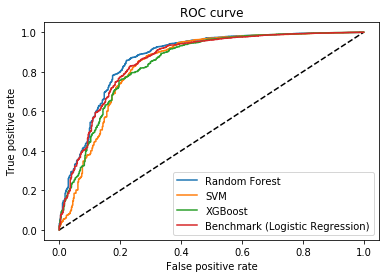

In [95]:
# this code has been extracted from at hase been modified slightly
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(rf_fpr, rf_tpr, label='Random Forest')
plt.plot(svm_fpr, svm_tpr, label='SVM')
plt.plot(xg_fpr, xg_tpr, label='XGBoost')
plt.plot(lr_fpr, lr_tpr, label='Benchmark (Logistic Regression)')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [96]:
from sklearn.model_selection import train_test_split

In [97]:
access_1hot.shape

(24576, 14064)

In [101]:
# plot_learning_curves function taken from "Hands-On Machine Learning with Scikit-Learn & Tensorflow by Aurélion Géron
# (O'Reilly). Copyright 2017 Aurélion Géron, 978-1-491-96229-9, Page 124
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify=y)
    train_errors, val_errors = [], []
    for m in range(1, X_train.shape[0], 1000):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        try:
            train_errors.append(roc_auc_score(y_train_predict, y_train[:m]))
            val_errors.append(roc_auc_score(y_val_predict, y_val))
        except ValueError:
            pass
    plt.plot(train_errors, 'r-+', linewidth=2, label='train')
    plt.plot(val_errors, 'b-', linewidth=3, label='val')
    plt.xlabel('Training set size [in 1000]')
    plt.ylabel('ROC auc score')
    plt.title('Learning curves')
    plt.legend()

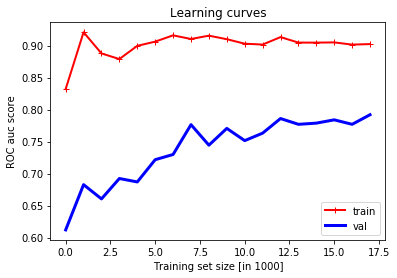

In [102]:
plot_learning_curves(xgboost_final, access_1hot, access_labels)